# Library

In [160]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import Callback
from keras import layers
from keras.regularizers import l2
from imblearn.over_sampling import SMOTE
from nlp_id.lemmatizer import Lemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from collections import Counter
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from pandas import read_csv
from string import punctuation

import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import re, json
np.set_printoptions(linewidth=np.inf)

from matplotlib import pyplot as plt

# Dataset

In [136]:
# LOAD dataset
dataset_path = './dataset/dataset_minecraft.csv'
df = read_csv(dataset_path)
df = df.dropna()
df = df.drop_duplicates()
print("\"{}\" is loaded succesfully".format(dataset_path))

dataset = df['Text Clean'].to_numpy()
label = df['Sentiment'].to_numpy()

# features = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
# features.info()

"./dataset/dataset_minecraft.csv" is loaded succesfully


# Features Extraction

In [163]:
def preProcessing(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', str(text))
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', punctuation))
    text = text.strip(' ')
    text = text.lower()

    with open('./resource/slangwords_dict.txt', 'r') as file :
        slangwords = json.loads(file.readline())
    words = text.split()
    fixed_words = []
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else :
            fixed_words.append(word)
    text = ' '.join(fixed_words)
    text = word_tokenize(text)
    
    with open('./resource/stopwords.txt', 'r') as file:
        stopwords = file.readlines()
    stopwordsDict =[]
    for word in stopwords:
        word = word.replace('\n', '')
        stopwordsDict.append(word)
    fix_words = []
    for txt in text:
        if txt not in stopwordsDict:
            fix_words.append(txt)
    text = fix_words

    lemmatizer = Lemmatizer()
    text = [lemmatizer.lemmatize(word.lower()) for word in text]

    return ' '.join(word for word in text)

In [148]:
print(X_tfidf[0].toarray().shape)

(1, 13998)


In [149]:
X = df['Text Clean']
y = df['Sentiment']

# tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8)
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

# save tfidf
with open('./tfidf/tfidfVectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

features = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())                   # create dataframe
# features.to_csv('./features/tfidf_mc_15000.csv', index=False)                                     # save features
print("Features Shape : ", features.shape)
print("\nSebelum Upsampling\n", y.value_counts())

# Upsampling data
smote = SMOTE()
x_over, y_over = smote.fit_resample(X_tfidf, y)
print("\nSetelah Upsampling\n", y_over.value_counts())

X_train, X_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=42)     # splitting features
print("\nData Testing : ", len(y_train))
print("Data Testing : ", len(y_test))

Features Shape :  (14637, 13998)

Sebelum Upsampling
 Sentiment
positive    7034
negative    6122
neutral     1481
Name: count, dtype: int64

Setelah Upsampling
 Sentiment
negative    7034
positive    7034
neutral     7034
Name: count, dtype: int64

Data Testing :  16881
Data Testing :  4221


# Model Training

### SVM

In [ ]:
from sklearn.model_selection import grid

In [115]:
# Inisiasi SVM Model
# svc_model = SVC(kernel='linear', random_state=42)   # SVM linear
svc_model = SVC(kernel='rbf', gamma=0.1, random_state=42)

# train model
svc_model.fit(X_train, y_train)

SVC(gamma=0.1, random_state=42)

Aktual   : ['negative' 'neutral' 'positive' 'neutral' 'negative' 'negative' 'negative' 'negative' 'negative' 'neutral']
Prediksi : ['negative' 'neutral' 'positive' 'negative' 'positive' 'negative' 'negative' 'negative' 'negative' 'negative']

Akurasi model SVM : 84.58%

               precision    recall  f1-score   support

    negative       0.77      0.90      0.83      1415
     neutral       0.96      0.77      0.85      1408
    positive       0.85      0.87      0.86      1398

    accuracy                           0.85      4221
   macro avg       0.86      0.85      0.85      4221
weighted avg       0.86      0.85      0.85      4221



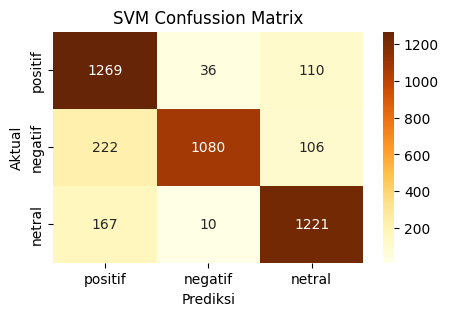

In [116]:
# make prediction
y_pred = svc_model.predict(X_test)

# cetak 10 hasil prediksi
print("Aktual   :", np.array(y_test)[:10])
print("Prediksi :", y_pred[:10])

# akurasi
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"\nAkurasi model SVM : {accuracy:.2f}%")

print("\n", classification_report(y_test, y_pred))

svm_confuss = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(svm_confuss, annot=True, fmt='d', cmap='YlOrBr', xticklabels=['positif', 'negatif', 'netral'], yticklabels=['positif', 'negatif', 'netral'])
plt.title("SVM Confussion Matrix")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [177]:
def inferenceTfidf(text):
    with open('./tfidf/tfidfVectorizer.pkl', 'rb') as file:
        tfV = pickle.load(file)
        
    text = preProcessing(text)
    x = tfV.transform([text]).toarray()
    pred = svc_model.predict(x)
    return print(f"Sentiment dari \"{text}\" : \033[1m{pred[0]}")

inferenceTfidf("Gamenya ampas dan sering ngelag anjing")
# pred = svc_model.predict(inferenceTfidf(["Game bagus"]))

Sentiment dari "gamenya ampas ngelag anjing" : negative


# Features Extraction

In [ ]:
# feature_train, feature_test, label_train, label_test = train_test_split(dataset, label, test_size=0.3, random_state=42)

### Dataset

In [4]:
# MAX WORD LENGTH
word_len = []
for word in dataset:
    word_len.append(len(word.split()))
max_word_length = max(word_len)
print("Max Word Length :\033[1m", max_word_length)
####################################################################################

# UNIQUE WORDS
def counter_word(texts):
    count = Counter()
    for text in texts.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(df['Text Clean'])
num_unique_words = len(counter) # 14000
print("\nUnique words :\033[1m", num_unique_words)
####################################################################################

# TOKENIZING
# tokenizing dataset
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(dataset)
# print(tokenizer.word_index.keys())
# print(tokenizer.word_index.values())
####################################################################################

# FEATURE ENCODER
# dictionary for word
word_index = tokenizer.word_index
# turn dataset to sequence
dataset_seq = tokenizer.texts_to_sequences(dataset)
print("\n===Feature Encoder Test=== ")
print("Text Original : ", dataset[6])
print("Text Encoded  : ", dataset_seq[6])
####################################################################################

# FEATURE DECODER
# Flip word dictionary (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])
decoded_text = decode(dataset_seq[6])
print("\n===Feature Decoder Test=== ")
print("Text Sequence : ", dataset_seq[6])
print("Text Decoded  : ", decoded_text)
####################################################################################

# Padding
dataset_padded = pad_sequences(dataset_seq, maxlen=max_word_length, padding="pre", truncating="pre")
print("\nPadding Test : ")
print("Text Ori   : ", dataset[6])
print("Text Token : ", dataset_seq[6])
print("Token Pad  : ", dataset_padded[6])
####################################################################################

Max Word Length : 88

Unique words : 14000

===Feature Encoder Test=== 
Text Original :  game nya bagus serutapi freeze kamera detik menggangu survivalsaya bikin lag frame drop freeze kamera baik cepat baik
Text Encoded  :  [1, 2, 3, 1548, 132, 466, 143, 346, 4902, 39, 42, 81, 78, 132, 466, 6, 133, 6]

===Feature Decoder Test=== 
Text Sequence :  [1, 2, 3, 1548, 132, 466, 143, 346, 4902, 39, 42, 81, 78, 132, 466, 6, 133, 6]
Text Decoded  :  game nya bagus serutapi freeze kamera detik menggangu survivalsaya bikin lag frame drop freeze kamera baik cepat baik

Padding Test : 
Text Ori   :  game nya bagus serutapi freeze kamera detik menggangu survivalsaya bikin lag frame drop freeze kamera baik cepat baik
Text Token :  [1, 2, 3, 1548, 132, 466, 143, 346, 4902, 39, 42, 81, 78, 132, 466, 6, 133, 6]
Token Pad  :  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 

### Label

In [5]:
# LABEL ENCODE
encoder = OneHotEncoder(sparse_output=False)
label_one_hot = encoder.fit_transform(label.reshape(-1, 1))
print("\n===Label Encoder Test=== ")
print(encoder.get_feature_names_out())
print("Onehot \"{}\" : {}".format(df['Sentiment'][0], label_one_hot[0]))


===Label Encoder Test=== 
['x0_negative' 'x0_neutral' 'x0_positive']
Onehot "negative" : [1. 0. 0.]


### Oversampling

In [6]:
smote = SMOTE()
x_over, y_over = smote.fit_resample(dataset_padded, label_one_hot)

In [7]:
# BEFORE OVERSAMPLING
df.Sentiment.value_counts()

Sentiment
positive    7034
negative    6122
neutral     1481
Name: count, dtype: int64

In [8]:
# AFTER OVERSAMPLING
def decoderOnehot(data):
    label = encoder.inverse_transform([data])
    return label[0][0]
    
new_df = pd.DataFrame(list(zip(x_over, y_over)), columns=['features', 'label'])
new_df['label'] = new_df['label'].apply(decoderOnehot)
new_df['label'].value_counts()
# new_df

label
negative    7034
positive    7034
neutral     7034
Name: count, dtype: int64

### Splitting

In [9]:
print(x_over.shape, y_over.shape)
X_train, X_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.3, random_state=42)

(21102, 88) (21102, 3)


In [10]:
train_df = pd.DataFrame(zip(y_train), columns=['label'])
train_df['label'] = train_df['label'].apply(decoderOnehot)
train_df.value_counts()

label   
neutral     4945
negative    4916
positive    4910
Name: count, dtype: int64

In [11]:
test_df = pd.DataFrame(zip(y_test), columns=['label'])
test_df['label'] = test_df['label'].apply(decoderOnehot)
test_df.value_counts()

label   
positive    2124
negative    2118
neutral     2089
Name: count, dtype: int64

# Model

In [12]:
# DEFINE CALLBACK
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') >= 0.92 and logs.get('val_accuracy') >= 0.92):
            self.ltm.stop_training=True
            print('\nModel telah mencapai akurasi 92%')

In [22]:
# Feature Extraction
wordEmbedding = layers.Embedding(
                        input_dim=num_unique_words, 
                        output_dim=64, 
                        input_length=max_word_length,
                        mask_zero=True                  # cuz i use zero padding so model will ignore 0 value
                        )

lstm = Sequential([
    wordEmbedding,
    # layers.Bidirectional(layers.LSTM(88, dropout=0.2, kernel_regularizer=l2(0.01))),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.3, kernel_regularizer=l2(0.01))),
    layers.Bidirectional(layers.LSTM(64, dropout=0.3, kernel_regularizer=l2(0.01))),
    # layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])
lstm.summary()

lstm.compile(loss=categorical_crossentropy,
             optimizer=Adam(learning_rate=0.00001),
             metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 88, 64)            896000    
                                                                 
 bidirectional_13 (Bidirect  (None, 88, 128)           66048     
 ional)                                                          
                                                                 
 bidirectional_14 (Bidirect  (None, 128)               98816     
 ional)                                                          
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 3)                

In [24]:
history_lstm = lstm.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        batch_size=64, 
                        epochs=500, 
                        callbacks=myCallback())

Epoch 1/500
231/231 [==============================] - 104s 451ms/step - loss: 6.2515 - accuracy: 0.3262 - val_loss: 6.1132 - val_accuracy: 0.3262
Epoch 2/500
231/231 [==============================] - 83s 360ms/step - loss: 5.9807 - accuracy: 0.3411 - val_loss: 5.8489 - val_accuracy: 0.3511
Epoch 3/500
231/231 [==============================] - 81s 351ms/step - loss: 5.7224 - accuracy: 0.3486 - val_loss: 5.5966 - val_accuracy: 0.3772
Epoch 4/500
231/231 [==============================] - 81s 353ms/step - loss: 5.4759 - accuracy: 0.3537 - val_loss: 5.3555 - val_accuracy: 0.3876
Epoch 5/500
231/231 [==============================] - 80s 345ms/step - loss: 5.2397 - accuracy: 0.3604 - val_loss: 5.1242 - val_accuracy: 0.3781
Epoch 6/500
231/231 [==============================] - 79s 341ms/step - loss: 5.0131 - accuracy: 0.3665 - val_loss: 4.9016 - val_accuracy: 0.3846
Epoch 7/500
231/231 [==============================] - 79s 341ms/step - loss: 4.7953 - accuracy: 0.3807 - val_loss: 4.6889 

KeyboardInterrupt: 